In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from going_modular import data_setup, engine
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from pathlib import Path

import requests

data_path = Path("./alphanumber/")
image_path = data_path
train_dir = image_path / "train"
test_dir = image_path / "test"
validate = image_path / "validation"



BATCH_SIZE = 32


In [4]:
train_dir

PosixPath('alphanumber/train')

In [5]:
test_dir

PosixPath('alphanumber/test')

In [6]:
normalize = transforms.Normalize(mean=[0.5],
                                 std=[0.5])


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # FORCE 1 channel
    transforms.Resize((24, 24)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
]) 

In [7]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0xfc9d1c9336b0>,
 ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  'lower_a',
  'lower_b',
  'lower_c',
  'lower_d',
  'lower_e',
  'lower_f',
  'lower_g',
  'lower_h',
  'lower_i',
  'lower_j',
  'lower_k',
  'lower_l',
  'lower_m',
  'lower_n',
  'lower_o',
  'lower_p',
  'lower_q',
  'lower_r',
  'lower_s',
  'lower_t',
  'lower_u',
  'lower_v',
  'lower_w',
  'lower_x',
  'lower_y',
  'lower_z',
  'upper_A',
  'upper_B',
  'upper_C',
  'upper_D',
  'upper_E',
  'upper_F',
  'upper_G',
  'upper_H',
  'upper_I',
  'upper_J',
  'upper_K',
  'upper_L',
  'upper_M',
  'upper_N',
  'upper_O',
  'upper_P',
  'upper_Q',
  'upper_R',
  'upper_S',
  'upper_T',
  'upper_U',
  'upper_V',
  'upper_W',
  'upper_X',
  'upper_Y',
  'upper_Z'])

In [8]:
print(len(train_dataloader))
print(len(test_dataloader))

2139
611


In [9]:
import torch
from torch import nn


class HandwrittenCNN(nn.Module):
    def __init__(self, input_channels: int = 1, num_classes: int = 62):
        super().__init__()

        # -------- Feature extractor --------
        self.features = nn.Sequential(
            # Block 1: 1 → 32
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 24x24 → 12x12

            # Block 2: 32 → 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12 → 6x6

            # Block 3: 64 → 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # -------- Classifier --------
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x: torch.Tensor):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [10]:
class HandwrittenCNN_Deep(nn.Module):
    def __init__(self, input_channels=1, num_classes=62):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 6x6

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Extra depth
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


In [11]:
class HandwrittenCNN_Wide(nn.Module):
    def __init__(self, input_channels=1, num_classes=62):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


In [12]:
class HandwrittenCNN_DropoutLight(nn.Module):
    def __init__(self, input_channels=1, num_classes=62):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.2),  # lighter dropout
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


In [13]:
class HandwrittenCNN_Residual(nn.Module):
    def __init__(self, input_channels=1, num_classes=62):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32)
        )

        self.pool = nn.MaxPool2d(2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        residual = self.conv1(x)
        x = self.conv2(residual)
        x = nn.ReLU()(x + residual)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.conv4(x)

        return self.classifier(x)


In [14]:
class HandwrittenCNN_Lightweight(nn.Module):
    def __init__(self, input_channels=1, num_classes=62):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


In [15]:
import torch

from going_modular import model_builder
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate an instance of the model from the "model_builder.py" script
handwrittenCNN = HandwrittenCNN().to(device)
handwrittenCNN_Deep = HandwrittenCNN_Deep().to(device)
handwrittenCNN_Wide = HandwrittenCNN_Deep().to(device)
handwrittenCNN_DropoutLight = HandwrittenCNN_DropoutLight().to(device)
handwrittenCNN_Residual = HandwrittenCNN_Residual().to(device)
handwrittenCNN_Lightweight = HandwrittenCNN_Lightweight().to(device)


/home/aispark/Project/CV/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


In [16]:
from torchinfo import summary

summary(handwrittenCNN, 
        input_size=(1, 1, 24, 24), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
HandwrittenCNN (HandwrittenCNN)          [1, 1, 24, 24]       [1, 62]              --                   True
├─Sequential (features)                  [1, 1, 24, 24]       [1, 128, 6, 6]       --                   True
│    └─Conv2d (0)                        [1, 1, 24, 24]       [1, 32, 24, 24]      320                  True
│    └─BatchNorm2d (1)                   [1, 32, 24, 24]      [1, 32, 24, 24]      64                   True
│    └─ReLU (2)                          [1, 32, 24, 24]      [1, 32, 24, 24]      --                   --
│    └─MaxPool2d (3)                     [1, 32, 24, 24]      [1, 32, 12, 12]      --                   --
│    └─Conv2d (4)                        [1, 32, 12, 12]      [1, 64, 12, 12]      18,496               True
│    └─BatchNorm2d (5)                   [1, 64, 12, 12]      [1, 64, 12, 12]      128                  True
│    └─ReLU (6)   

In [17]:
summary(handwrittenCNN_Deep, 
        input_size=(1, 1, 24, 24), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
HandwrittenCNN_Deep (HandwrittenCNN_Deep)     [1, 1, 24, 24]       [1, 62]              --                   True
├─Sequential (features)                       [1, 1, 24, 24]       [1, 256, 6, 6]       --                   True
│    └─Conv2d (0)                             [1, 1, 24, 24]       [1, 32, 24, 24]      320                  True
│    └─BatchNorm2d (1)                        [1, 32, 24, 24]      [1, 32, 24, 24]      64                   True
│    └─ReLU (2)                               [1, 32, 24, 24]      [1, 32, 24, 24]      --                   --
│    └─MaxPool2d (3)                          [1, 32, 24, 24]      [1, 32, 12, 12]      --                   --
│    └─Conv2d (4)                             [1, 32, 12, 12]      [1, 64, 12, 12]      18,496               True
│    └─BatchNorm2d (5)                        [1, 64, 12, 12]      [1, 64, 12, 12]     

In [18]:
summary(handwrittenCNN_Wide, 
        input_size=(1, 1, 24, 24), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
HandwrittenCNN_Deep (HandwrittenCNN_Deep)     [1, 1, 24, 24]       [1, 62]              --                   True
├─Sequential (features)                       [1, 1, 24, 24]       [1, 256, 6, 6]       --                   True
│    └─Conv2d (0)                             [1, 1, 24, 24]       [1, 32, 24, 24]      320                  True
│    └─BatchNorm2d (1)                        [1, 32, 24, 24]      [1, 32, 24, 24]      64                   True
│    └─ReLU (2)                               [1, 32, 24, 24]      [1, 32, 24, 24]      --                   --
│    └─MaxPool2d (3)                          [1, 32, 24, 24]      [1, 32, 12, 12]      --                   --
│    └─Conv2d (4)                             [1, 32, 12, 12]      [1, 64, 12, 12]      18,496               True
│    └─BatchNorm2d (5)                        [1, 64, 12, 12]      [1, 64, 12, 12]     

In [19]:
summary(handwrittenCNN_DropoutLight, 
        input_size=(1, 1, 24, 24), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
HandwrittenCNN_DropoutLight (HandwrittenCNN_DropoutLight)    [1, 1, 24, 24]       [1, 62]              --                   True
├─Sequential (features)                                      [1, 1, 24, 24]       [1, 128, 6, 6]       --                   True
│    └─Conv2d (0)                                            [1, 1, 24, 24]       [1, 32, 24, 24]      320                  True
│    └─BatchNorm2d (1)                                       [1, 32, 24, 24]      [1, 32, 24, 24]      64                   True
│    └─ReLU (2)                                              [1, 32, 24, 24]      [1, 32, 24, 24]      --                   --
│    └─MaxPool2d (3)                                         [1, 32, 24, 24]      [1, 32, 12, 12]      --                   --
│    └─Conv2d (4)                                            [1, 32, 12, 12]      [1, 64, 12, 12

In [20]:
summary(handwrittenCNN_Residual, 
        input_size=(1, 1, 24, 24), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
HandwrittenCNN_Residual (HandwrittenCNN_Residual)  [1, 1, 24, 24]       [1, 62]              --                   True
├─Sequential (conv1)                               [1, 1, 24, 24]       [1, 32, 24, 24]      --                   True
│    └─Conv2d (0)                                  [1, 1, 24, 24]       [1, 32, 24, 24]      320                  True
│    └─BatchNorm2d (1)                             [1, 32, 24, 24]      [1, 32, 24, 24]      64                   True
│    └─ReLU (2)                                    [1, 32, 24, 24]      [1, 32, 24, 24]      --                   --
├─Sequential (conv2)                               [1, 32, 24, 24]      [1, 32, 24, 24]      --                   True
│    └─Conv2d (0)                                  [1, 32, 24, 24]      [1, 32, 24, 24]      9,248                True
│    └─BatchNorm2d (1)                       

In [21]:
summary(handwrittenCNN_Lightweight, 
        input_size=(1, 1, 24, 24), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
HandwrittenCNN_Lightweight (HandwrittenCNN_Lightweight)      [1, 1, 24, 24]       [1, 62]              --                   True
├─Sequential (features)                                      [1, 1, 24, 24]       [1, 64, 6, 6]        --                   True
│    └─Conv2d (0)                                            [1, 1, 24, 24]       [1, 16, 24, 24]      160                  True
│    └─BatchNorm2d (1)                                       [1, 16, 24, 24]      [1, 16, 24, 24]      32                   True
│    └─ReLU (2)                                              [1, 16, 24, 24]      [1, 16, 24, 24]      --                   --
│    └─MaxPool2d (3)                                         [1, 16, 24, 24]      [1, 16, 12, 12]      --                   --
│    └─Conv2d (4)                                            [1, 16, 12, 12]      [1, 32, 12, 12

In [22]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [23]:
X, y = next(iter(train_dataloader))
print(X.shape)

torch.Size([32, 1, 24, 24])


In [27]:
# 1. Create epochs list
num_epochs = [5, 10, 15, 20]

# 2. Create models list (need to create a new model for each experiment)
model_pool = {
    "handwrittenCNN": handwrittenCNN,
    "handwrittenCNN_Deep": handwrittenCNN_Deep,
    "handwrittenCNN_Wide": handwrittenCNN_Wide,
    "handwrittenCNN_DropoutLight": handwrittenCNN_DropoutLight,
    "handwrittenCNN_Residual": handwrittenCNN_Residual,
    "handwrittenCNN_Lightweight": handwrittenCNN_Lightweight,
}

models = list(model_pool.keys())
# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"dataset": train_dataloader}




In [30]:
from typing import Dict, List
from tqdm.auto import tqdm
from going_modular.engine import train_step, test_step, train_TSB
from torch.utils.tensorboard import SummaryWriter
from going_modular.writer import create_writer

In [ ]:
%%time
from going_modular.utils import save_model


def reset_weights(model):
    for layer in model.modules():
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()

experiment_number = 0


for dataloader_name, train_dataloader in train_dataloaders.items():

    for epochs in num_epochs:

        for model_name in models:

            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            # 🔑 Get the already-created model by name
            model = model_pool[model_name]

            # 🔑 Reset weights so each experiment starts fresh
            reset_weights(model)
            model = model.to(device)
            model.train()

            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(
                params=model.parameters(),
                lr=0.001
            )

            train_TSB(
                model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                writer=create_writer(
                    experiment_name=dataloader_name,
                    model_name=model_name,
                    extra=f"{epochs}_epochs"
                )
            )

            save_filepath = f"{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(
                model=model,
                target_dir="models",
                model_name=save_filepath
            )

            print("-" * 50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: handwrittenCNN
[INFO] DataLoader: dataset
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs/2026-01-12/dataset/handwrittenCNN/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1041 | train_acc: 0.6684 | test_loss: 0.5177 | test_acc: 0.8149
Epoch: 2 | train_loss: 0.6434 | train_acc: 0.7881 | test_loss: 0.4090 | test_acc: 0.8489
Epoch: 3 | train_loss: 0.5380 | train_acc: 0.8150 | test_loss: 0.3729 | test_acc: 0.8635
Epoch: 4 | train_loss: 0.4740 | train_acc: 0.8341 | test_loss: 0.3384 | test_acc: 0.8716
Epoch: 5 | train_loss: 0.4242 | train_acc: 0.8503 | test_loss: 0.3326 | test_acc: 0.8779
[INFO] Saving model to: models/handwrittenCNN_dataset_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: handwrittenCNN_Deep
[INFO] DataLoader: dataset
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs/2026-01-12/dataset/handwrittenCNN_Deep/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3469 | train_acc: 0.5966 | test_loss: 0.5313 | test_acc: 0.8139
Epoch: 2 | train_loss: 0.7958 | train_acc: 0.7426 | test_loss: 0.4370 | test_acc: 0.8447
Epoch: 3 | train_loss: 0.6561 | train_acc: 0.7799 | test_loss: 0.4003 | test_acc: 0.8566
Epoch: 4 | train_loss: 0.5563 | train_acc: 0.8110 | test_loss: 0.3644 | test_acc: 0.8630
Epoch: 5 | train_loss: 0.4794 | train_acc: 0.8341 | test_loss: 0.3368 | test_acc: 0.8775
[INFO] Saving model to: models/handwrittenCNN_Deep_dataset_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: handwrittenCNN_Wide
[INFO] DataLoader: dataset
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs/2026-01-12/dataset/handwrittenCNN_Wide/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1889 | train_acc: 0.6421 | test_loss: 0.5132 | test_acc: 0.8196
Epoch: 2 | train_loss: 0.6748 | train_acc: 0.7787 | test_loss: 0.4094 | test_acc: 0.8502
Epoch: 3 | train_loss: 0.5454 | train_acc: 0.8165 | test_loss: 0.3740 | test_acc: 0.8594
Epoch: 4 | train_loss: 0.4678 | train_acc: 0.8379 | test_loss: 0.3365 | test_acc: 0.8763
Epoch: 5 | train_loss: 0.4095 | train_acc: 0.8543 | test_loss: 0.3356 | test_acc: 0.8741
[INFO] Saving model to: models/handwrittenCNN_Wide_dataset_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: handwrittenCNN_DropoutLight
[INFO] DataLoader: dataset
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs/2026-01-12/dataset/handwrittenCNN_DropoutLight/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7798 | train_acc: 0.7578 | test_loss: 0.4601 | test_acc: 0.8383
Epoch: 2 | train_loss: 0.4473 | train_acc: 0.8413 | test_loss: 0.3772 | test_acc: 0.8616
Epoch: 3 | train_loss: 0.3672 | train_acc: 0.8663 | test_loss: 0.3498 | test_acc: 0.8697
Epoch: 4 | train_loss: 0.3189 | train_acc: 0.8807 | test_loss: 0.3422 | test_acc: 0.8727
Epoch: 5 | train_loss: 0.2767 | train_acc: 0.8943 | test_loss: 0.3219 | test_acc: 0.8822
[INFO] Saving model to: models/handwrittenCNN_DropoutLight_dataset_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: handwrittenCNN_Residual
[INFO] DataLoader: dataset
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs/2026-01-12/dataset/handwrittenCNN_Residual/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0345 | train_acc: 0.6872 | test_loss: 0.5014 | test_acc: 0.8209
Epoch: 2 | train_loss: 0.5993 | train_acc: 0.7986 | test_loss: 0.3773 | test_acc: 0.8601
Epoch: 3 | train_loss: 0.4967 | train_acc: 0.8276 | test_loss: 0.3475 | test_acc: 0.8727
Epoch: 4 | train_loss: 0.4421 | train_acc: 0.8436 | test_loss: 0.3382 | test_acc: 0.8750
Epoch: 5 | train_loss: 0.3956 | train_acc: 0.8579 | test_loss: 0.3326 | test_acc: 0.8784
[INFO] Saving model to: models/handwrittenCNN_Residual_dataset_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: handwrittenCNN_Lightweight
[INFO] DataLoader: dataset
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs/2026-01-12/dataset/handwrittenCNN_Lightweight/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9782 | train_acc: 0.7051 | test_loss: 0.4752 | test_acc: 0.8325
Epoch: 2 | train_loss: 0.5670 | train_acc: 0.8061 | test_loss: 0.4123 | test_acc: 0.8524
Epoch: 3 | train_loss: 0.4849 | train_acc: 0.8312 | test_loss: 0.3850 | test_acc: 0.8620
Epoch: 4 | train_loss: 0.4309 | train_acc: 0.8466 | test_loss: 0.3637 | test_acc: 0.8650
Epoch: 5 | train_loss: 0.3966 | train_acc: 0.8569 | test_loss: 0.3477 | test_acc: 0.8691
[INFO] Saving model to: models/handwrittenCNN_Lightweight_dataset_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: handwrittenCNN
[INFO] DataLoader: dataset
[INFO] Number of epochs: 10
[INFO] Created SummaryWriter, saving to: runs/2026-01-12/dataset/handwrittenCNN/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1036 | train_acc: 0.6665 | test_loss: 0.4789 | test_acc: 0.8350
Epoch: 2 | train_loss: 0.6512 | train_acc: 0.7837 | test_loss: 0.4056 | test_acc: 0.8491
Epoch: 3 | train_loss: 0.5365 | train_acc: 0.8188 | test_loss: 0.3731 | test_acc: 0.8613
Epoch: 4 | train_loss: 0.4784 | train_acc: 0.8348 | test_loss: 0.3449 | test_acc: 0.8728
Epoch: 5 | train_loss: 0.4285 | train_acc: 0.8482 | test_loss: 0.3329 | test_acc: 0.8765
Epoch: 6 | train_loss: 0.3938 | train_acc: 0.8594 | test_loss: 0.3238 | test_acc: 0.8780
Epoch: 7 | train_loss: 0.3574 | train_acc: 0.8698 | test_loss: 0.3233 | test_acc: 0.8806
Epoch: 8 | train_loss: 0.3306 | train_acc: 0.8771 | test_loss: 0.3134 | test_acc: 0.8861
Epoch: 9 | train_loss: 0.3110 | train_acc: 0.8835 | test_loss: 0.3206 | test_acc: 0.8847
Epoch: 10 | train_loss: 0.2921 | train_acc: 0.8888 | test_loss: 0.3196 | test_acc: 0.8894
[INFO] Saving model to: models/handwrittenCNN_dataset_10_epochs.pth
-----------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3225 | train_acc: 0.6031 | test_loss: 0.5317 | test_acc: 0.8149
Epoch: 2 | train_loss: 0.7754 | train_acc: 0.7458 | test_loss: 0.4284 | test_acc: 0.8469
Epoch: 3 | train_loss: 0.6323 | train_acc: 0.7895 | test_loss: 0.3816 | test_acc: 0.8614
Epoch: 4 | train_loss: 0.5347 | train_acc: 0.8181 | test_loss: 0.3496 | test_acc: 0.8735
Epoch: 5 | train_loss: 0.4658 | train_acc: 0.8372 | test_loss: 0.3344 | test_acc: 0.8792
Epoch: 6 | train_loss: 0.4148 | train_acc: 0.8533 | test_loss: 0.3286 | test_acc: 0.8778
Epoch: 7 | train_loss: 0.3723 | train_acc: 0.8660 | test_loss: 0.3205 | test_acc: 0.8863
Epoch: 8 | train_loss: 0.3340 | train_acc: 0.8782 | test_loss: 0.3233 | test_acc: 0.8867
Epoch: 9 | train_loss: 0.3064 | train_acc: 0.8858 | test_loss: 0.3119 | test_acc: 0.8907
Epoch: 10 | train_loss: 0.2834 | train_acc: 0.8933 | test_loss: 0.3112 | test_acc: 0.8925
[INFO] Saving model to: models/handwrittenCNN_Deep_dataset_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2352 | train_acc: 0.6273 | test_loss: 0.5366 | test_acc: 0.8072
Epoch: 2 | train_loss: 0.7254 | train_acc: 0.7589 | test_loss: 0.4215 | test_acc: 0.8435
Epoch: 3 | train_loss: 0.5787 | train_acc: 0.8029 | test_loss: 0.3648 | test_acc: 0.8639
Epoch: 4 | train_loss: 0.5035 | train_acc: 0.8264 | test_loss: 0.3466 | test_acc: 0.8717
Epoch: 5 | train_loss: 0.4407 | train_acc: 0.8450 | test_loss: 0.3366 | test_acc: 0.8765
Epoch: 6 | train_loss: 0.3968 | train_acc: 0.8583 | test_loss: 0.3187 | test_acc: 0.8862
Epoch: 7 | train_loss: 0.3560 | train_acc: 0.8699 | test_loss: 0.3197 | test_acc: 0.8850
Epoch: 8 | train_loss: 0.3182 | train_acc: 0.8809 | test_loss: 0.3250 | test_acc: 0.8841
Epoch: 9 | train_loss: 0.2927 | train_acc: 0.8896 | test_loss: 0.3152 | test_acc: 0.8868
Epoch: 10 | train_loss: 0.2694 | train_acc: 0.8973 | test_loss: 0.3108 | test_acc: 0.8940
[INFO] Saving model to: models/handwrittenCNN_Wide_dataset_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7799 | train_acc: 0.7557 | test_loss: 0.4638 | test_acc: 0.8363
Epoch: 2 | train_loss: 0.4483 | train_acc: 0.8420 | test_loss: 0.3730 | test_acc: 0.8628
Epoch: 3 | train_loss: 0.3741 | train_acc: 0.8640 | test_loss: 0.3614 | test_acc: 0.8703
Epoch: 4 | train_loss: 0.3273 | train_acc: 0.8790 | test_loss: 0.3414 | test_acc: 0.8738
Epoch: 5 | train_loss: 0.2892 | train_acc: 0.8912 | test_loss: 0.3251 | test_acc: 0.8813
Epoch: 6 | train_loss: 0.2573 | train_acc: 0.9003 | test_loss: 0.3194 | test_acc: 0.8855
Epoch: 7 | train_loss: 0.2314 | train_acc: 0.9106 | test_loss: 0.3226 | test_acc: 0.8844
Epoch: 8 | train_loss: 0.2094 | train_acc: 0.9167 | test_loss: 0.3362 | test_acc: 0.8896
Epoch: 9 | train_loss: 0.1903 | train_acc: 0.9264 | test_loss: 0.3404 | test_acc: 0.8867
Epoch: 10 | train_loss: 0.1755 | train_acc: 0.9308 | test_loss: 0.3395 | test_acc: 0.8927
[INFO] Saving model to: models/handwrittenCNN_DropoutLight_dataset_10_epochs.pth
----------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0593 | train_acc: 0.6783 | test_loss: 0.4651 | test_acc: 0.8348
Epoch: 2 | train_loss: 0.6168 | train_acc: 0.7932 | test_loss: 0.3834 | test_acc: 0.8603
Epoch: 3 | train_loss: 0.5149 | train_acc: 0.8220 | test_loss: 0.3643 | test_acc: 0.8687
Epoch: 4 | train_loss: 0.4553 | train_acc: 0.8404 | test_loss: 0.3298 | test_acc: 0.8714
Epoch: 5 | train_loss: 0.4091 | train_acc: 0.8534 | test_loss: 0.3255 | test_acc: 0.8801
Epoch: 6 | train_loss: 0.3734 | train_acc: 0.8649 | test_loss: 0.3093 | test_acc: 0.8862
Epoch: 7 | train_loss: 0.3407 | train_acc: 0.8747 | test_loss: 0.3057 | test_acc: 0.8868
Epoch: 8 | train_loss: 0.3173 | train_acc: 0.8799 | test_loss: 0.3106 | test_acc: 0.8891
Epoch: 9 | train_loss: 0.2928 | train_acc: 0.8885 | test_loss: 0.2973 | test_acc: 0.8935
Epoch: 10 | train_loss: 0.2692 | train_acc: 0.8965 | test_loss: 0.2965 | test_acc: 0.8935
[INFO] Saving model to: models/handwrittenCNN_Residual_dataset_10_epochs.pth
--------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9694 | train_acc: 0.7054 | test_loss: 0.5314 | test_acc: 0.8185
Epoch: 2 | train_loss: 0.5704 | train_acc: 0.8072 | test_loss: 0.4350 | test_acc: 0.8441
Epoch: 3 | train_loss: 0.4816 | train_acc: 0.8322 | test_loss: 0.3882 | test_acc: 0.8541
Epoch: 4 | train_loss: 0.4319 | train_acc: 0.8474 | test_loss: 0.3743 | test_acc: 0.8657
Epoch: 5 | train_loss: 0.3931 | train_acc: 0.8594 | test_loss: 0.3470 | test_acc: 0.8735
Epoch: 6 | train_loss: 0.3598 | train_acc: 0.8688 | test_loss: 0.3434 | test_acc: 0.8761
Epoch: 7 | train_loss: 0.3384 | train_acc: 0.8761 | test_loss: 0.3302 | test_acc: 0.8771
Epoch: 8 | train_loss: 0.3172 | train_acc: 0.8811 | test_loss: 0.3290 | test_acc: 0.8795
Epoch: 9 | train_loss: 0.2978 | train_acc: 0.8880 | test_loss: 0.3283 | test_acc: 0.8844
Epoch: 10 | train_loss: 0.2842 | train_acc: 0.8920 | test_loss: 0.3282 | test_acc: 0.8833
[INFO] Saving model to: models/handwrittenCNN_Lightweight_dataset_10_epochs.pth
-----------------------------

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0676 | train_acc: 0.6794 | test_loss: 0.4849 | test_acc: 0.8273
Epoch: 2 | train_loss: 0.6209 | train_acc: 0.7916 | test_loss: 0.4009 | test_acc: 0.8514
Epoch: 3 | train_loss: 0.5193 | train_acc: 0.8224 | test_loss: 0.3662 | test_acc: 0.8631
Epoch: 4 | train_loss: 0.4541 | train_acc: 0.8412 | test_loss: 0.3508 | test_acc: 0.8688
Epoch: 5 | train_loss: 0.4127 | train_acc: 0.8536 | test_loss: 0.3269 | test_acc: 0.8774
Epoch: 6 | train_loss: 0.3719 | train_acc: 0.8656 | test_loss: 0.3175 | test_acc: 0.8803
Epoch: 7 | train_loss: 0.3443 | train_acc: 0.8728 | test_loss: 0.3096 | test_acc: 0.8855
Epoch: 8 | train_loss: 0.3225 | train_acc: 0.8806 | test_loss: 0.3034 | test_acc: 0.8870
Epoch: 9 | train_loss: 0.2973 | train_acc: 0.8877 | test_loss: 0.3034 | test_acc: 0.8899
Epoch: 10 | train_loss: 0.2768 | train_acc: 0.8955 | test_loss: 0.3126 | test_acc: 0.8882
Epoch: 11 | train_loss: 0.2617 | train_acc: 0.9009 | test_loss: 0.3174 | test_acc: 0.8917
Epoch: 12 | train_l

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2962 | train_acc: 0.6111 | test_loss: 0.5342 | test_acc: 0.8098
Epoch: 2 | train_loss: 0.7449 | train_acc: 0.7533 | test_loss: 0.4054 | test_acc: 0.8520
Epoch: 3 | train_loss: 0.6045 | train_acc: 0.7965 | test_loss: 0.3747 | test_acc: 0.8650
Epoch: 4 | train_loss: 0.5117 | train_acc: 0.8226 | test_loss: 0.3436 | test_acc: 0.8736
Epoch: 5 | train_loss: 0.4495 | train_acc: 0.8409 | test_loss: 0.3572 | test_acc: 0.8738
Epoch: 6 | train_loss: 0.4004 | train_acc: 0.8565 | test_loss: 0.3211 | test_acc: 0.8831
Epoch: 7 | train_loss: 0.3540 | train_acc: 0.8718 | test_loss: 0.3339 | test_acc: 0.8808
Epoch: 8 | train_loss: 0.3184 | train_acc: 0.8811 | test_loss: 0.3136 | test_acc: 0.8898
Epoch: 9 | train_loss: 0.2890 | train_acc: 0.8912 | test_loss: 0.3150 | test_acc: 0.8911
Epoch: 10 | train_loss: 0.2733 | train_acc: 0.8952 | test_loss: 0.3124 | test_acc: 0.8926
Epoch: 11 | train_loss: 0.2509 | train_acc: 0.9032 | test_loss: 0.3205 | test_acc: 0.8912
Epoch: 12 | train_l

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5152 | train_acc: 0.5449 | test_loss: 0.5915 | test_acc: 0.7983
Epoch: 2 | train_loss: 0.9072 | train_acc: 0.7007 | test_loss: 0.4614 | test_acc: 0.8340
Epoch: 3 | train_loss: 0.6992 | train_acc: 0.7664 | test_loss: 0.3857 | test_acc: 0.8578
Epoch: 4 | train_loss: 0.5824 | train_acc: 0.7992 | test_loss: 0.3559 | test_acc: 0.8692
Epoch: 5 | train_loss: 0.5018 | train_acc: 0.8267 | test_loss: 0.3421 | test_acc: 0.8722
Epoch: 6 | train_loss: 0.4360 | train_acc: 0.8470 | test_loss: 0.3260 | test_acc: 0.8829
Epoch: 7 | train_loss: 0.3825 | train_acc: 0.8643 | test_loss: 0.3210 | test_acc: 0.8884
Epoch: 8 | train_loss: 0.3451 | train_acc: 0.8738 | test_loss: 0.3207 | test_acc: 0.8848
Epoch: 9 | train_loss: 0.3128 | train_acc: 0.8837 | test_loss: 0.3126 | test_acc: 0.8897
Epoch: 10 | train_loss: 0.2856 | train_acc: 0.8922 | test_loss: 0.3101 | test_acc: 0.8914
Epoch: 11 | train_loss: 0.2635 | train_acc: 0.8997 | test_loss: 0.3127 | test_acc: 0.8928
Epoch: 12 | train_l

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7764 | train_acc: 0.7568 | test_loss: 0.4385 | test_acc: 0.8414
Epoch: 2 | train_loss: 0.4464 | train_acc: 0.8410 | test_loss: 0.3750 | test_acc: 0.8628
Epoch: 3 | train_loss: 0.3669 | train_acc: 0.8666 | test_loss: 0.3425 | test_acc: 0.8773
Epoch: 4 | train_loss: 0.4705 | train_acc: 0.8344 | test_loss: 0.3391 | test_acc: 0.8762
Epoch: 5 | train_loss: 0.4217 | train_acc: 0.8498 | test_loss: 0.3335 | test_acc: 0.8763
Epoch: 6 | train_loss: 0.3878 | train_acc: 0.8597 | test_loss: 0.3164 | test_acc: 0.8861
Epoch: 7 | train_loss: 0.3543 | train_acc: 0.8729 | test_loss: 0.3183 | test_acc: 0.8845
Epoch: 8 | train_loss: 0.3239 | train_acc: 0.8803 | test_loss: 0.3121 | test_acc: 0.8856
Epoch: 9 | train_loss: 0.3017 | train_acc: 0.8875 | test_loss: 0.3095 | test_acc: 0.8885
Epoch: 10 | train_loss: 0.2857 | train_acc: 0.8921 | test_loss: 0.2999 | test_acc: 0.8934
Epoch: 11 | train_loss: 0.2660 | train_acc: 0.8984 | test_loss: 0.3146 | test_acc: 0.8935
Epoch: 12 | train_l

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0031 | train_acc: 0.7001 | test_loss: 0.4975 | test_acc: 0.8295
Epoch: 2 | train_loss: 0.5841 | train_acc: 0.8008 | test_loss: 0.4275 | test_acc: 0.8440
Epoch: 3 | train_loss: 0.4975 | train_acc: 0.8274 | test_loss: 0.3947 | test_acc: 0.8572
Epoch: 4 | train_loss: 0.4550 | train_acc: 0.8406 | test_loss: 0.3761 | test_acc: 0.8637
Epoch: 5 | train_loss: 0.4113 | train_acc: 0.8524 | test_loss: 0.3558 | test_acc: 0.8712
Epoch: 6 | train_loss: 0.3805 | train_acc: 0.8619 | test_loss: 0.3473 | test_acc: 0.8746
Epoch: 7 | train_loss: 0.3561 | train_acc: 0.8691 | test_loss: 0.3449 | test_acc: 0.8728
Epoch: 8 | train_loss: 0.3349 | train_acc: 0.8748 | test_loss: 0.3426 | test_acc: 0.8753
Epoch: 9 | train_loss: 0.3170 | train_acc: 0.8803 | test_loss: 0.3329 | test_acc: 0.8810
Epoch: 10 | train_loss: 0.3030 | train_acc: 0.8869 | test_loss: 0.3343 | test_acc: 0.8837
Epoch: 11 | train_loss: 0.2859 | train_acc: 0.8910 | test_loss: 0.3382 | test_acc: 0.8828
Epoch: 12 | train_l

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1717 | train_acc: 0.6464 | test_loss: 0.4817 | test_acc: 0.8285
Epoch: 2 | train_loss: 0.6935 | train_acc: 0.7703 | test_loss: 0.4188 | test_acc: 0.8498
Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8030 | test_loss: 0.3643 | test_acc: 0.8642
Epoch: 4 | train_loss: 0.5131 | train_acc: 0.8244 | test_loss: 0.3552 | test_acc: 0.8682
Epoch: 5 | train_loss: 0.4617 | train_acc: 0.8385 | test_loss: 0.3321 | test_acc: 0.8777
Epoch: 6 | train_loss: 0.4155 | train_acc: 0.8534 | test_loss: 0.3324 | test_acc: 0.8748
Epoch: 7 | train_loss: 0.3831 | train_acc: 0.8621 | test_loss: 0.3299 | test_acc: 0.8777
Epoch: 8 | train_loss: 0.3591 | train_acc: 0.8687 | test_loss: 0.3155 | test_acc: 0.8839
Epoch: 9 | train_loss: 0.3305 | train_acc: 0.8783 | test_loss: 0.3041 | test_acc: 0.8881
Epoch: 10 | train_loss: 0.3086 | train_acc: 0.8838 | test_loss: 0.3113 | test_acc: 0.8904
Epoch: 11 | train_loss: 0.2912 | train_acc: 0.8906 | test_loss: 0.3120 | test_acc: 0.8886
Epoch: 12 | train_l

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2635 | train_acc: 0.6211 | test_loss: 0.5223 | test_acc: 0.8159
Epoch: 2 | train_loss: 0.7393 | train_acc: 0.7575 | test_loss: 0.4387 | test_acc: 0.8394
Epoch: 3 | train_loss: 0.5927 | train_acc: 0.7992 | test_loss: 0.3786 | test_acc: 0.8594
Epoch: 4 | train_loss: 0.5064 | train_acc: 0.8252 | test_loss: 0.3472 | test_acc: 0.8710
Epoch: 5 | train_loss: 0.4506 | train_acc: 0.8422 | test_loss: 0.3280 | test_acc: 0.8792
Epoch: 6 | train_loss: 0.4000 | train_acc: 0.8569 | test_loss: 0.3212 | test_acc: 0.8799
Epoch: 7 | train_loss: 0.3575 | train_acc: 0.8702 | test_loss: 0.3182 | test_acc: 0.8867
Epoch: 8 | train_loss: 0.3200 | train_acc: 0.8809 | test_loss: 0.3242 | test_acc: 0.8876
Epoch: 9 | train_loss: 0.2988 | train_acc: 0.8889 | test_loss: 0.3061 | test_acc: 0.8935
Epoch: 10 | train_loss: 0.2724 | train_acc: 0.8964 | test_loss: 0.3200 | test_acc: 0.8900
Epoch: 11 | train_loss: 0.2507 | train_acc: 0.9033 | test_loss: 0.3208 | test_acc: 0.8867
Epoch: 12 | train_l

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2118 | train_acc: 0.6383 | test_loss: 0.5150 | test_acc: 0.8204
Epoch: 2 | train_loss: 0.6919 | train_acc: 0.7704 | test_loss: 0.4321 | test_acc: 0.8428
Epoch: 3 | train_loss: 0.5718 | train_acc: 0.8075 | test_loss: 0.3590 | test_acc: 0.8655
Epoch: 4 | train_loss: 0.4885 | train_acc: 0.8313 | test_loss: 0.3382 | test_acc: 0.8718
Epoch: 5 | train_loss: 0.4303 | train_acc: 0.8495 | test_loss: 0.3313 | test_acc: 0.8781
Epoch: 6 | train_loss: 0.3859 | train_acc: 0.8627 | test_loss: 0.3144 | test_acc: 0.8843
Epoch: 7 | train_loss: 0.3434 | train_acc: 0.8748 | test_loss: 0.3214 | test_acc: 0.8887
Epoch: 8 | train_loss: 0.3115 | train_acc: 0.8836 | test_loss: 0.3043 | test_acc: 0.8903
Epoch: 9 | train_loss: 0.2875 | train_acc: 0.8927 | test_loss: 0.3194 | test_acc: 0.8881
Epoch: 10 | train_loss: 0.2661 | train_acc: 0.8981 | test_loss: 0.3178 | test_acc: 0.8912
Epoch: 11 | train_loss: 0.2478 | train_acc: 0.9047 | test_loss: 0.3177 | test_acc: 0.8896
Epoch: 12 | train_l

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7776 | train_acc: 0.7565 | test_loss: 0.4606 | test_acc: 0.8396
Epoch: 2 | train_loss: 0.4476 | train_acc: 0.8430 | test_loss: 0.3717 | test_acc: 0.8652
Epoch: 3 | train_loss: 0.3735 | train_acc: 0.8657 | test_loss: 0.3481 | test_acc: 0.8737
Epoch: 4 | train_loss: 0.3189 | train_acc: 0.8802 | test_loss: 0.3415 | test_acc: 0.8723
Epoch: 5 | train_loss: 0.2829 | train_acc: 0.8912 | test_loss: 0.3137 | test_acc: 0.8889
Epoch: 6 | train_loss: 0.2529 | train_acc: 0.9010 | test_loss: 0.3333 | test_acc: 0.8834


In [36]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs


# ssh -L 6006:localhost:6006 aispark@192.168.1.201

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3137837), started 0:07:58 ago. (Use '!kill 3137837' to kill it.)

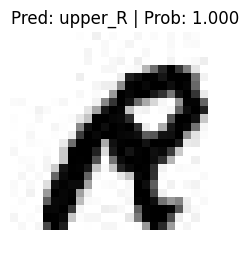

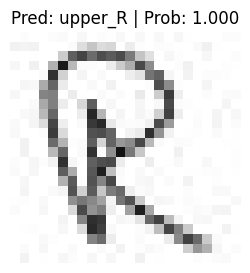

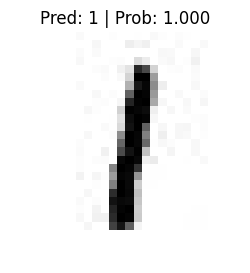

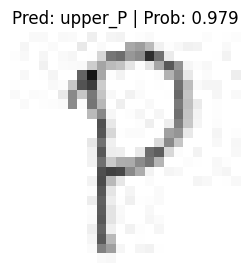

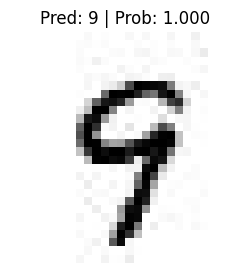

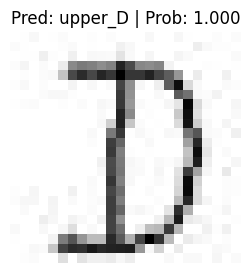

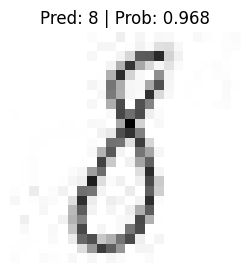

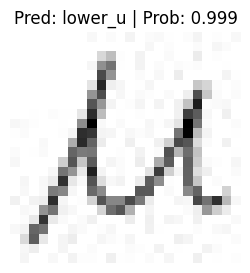

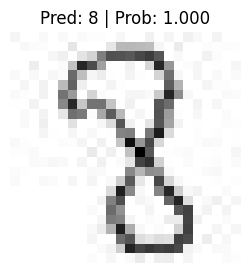

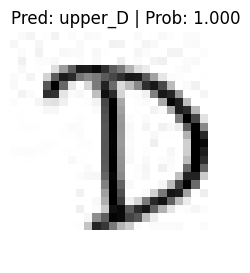

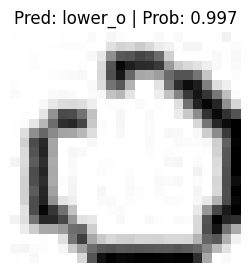

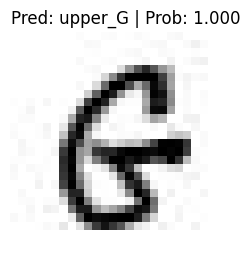

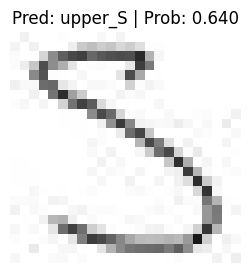

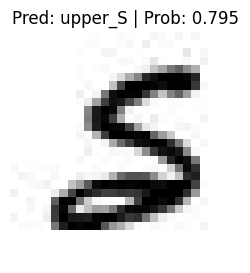

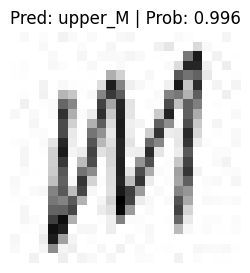

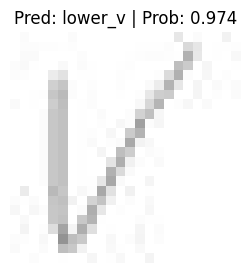

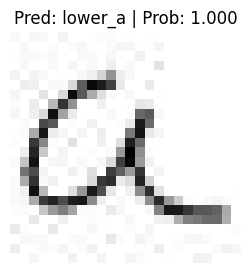

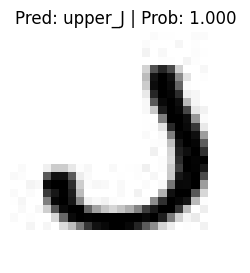

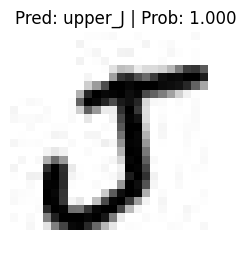

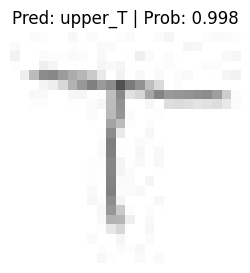

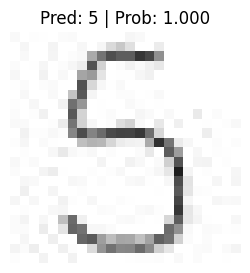

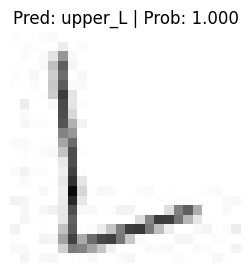

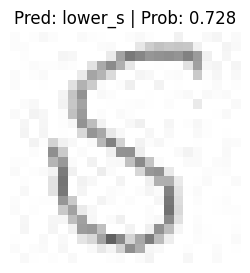

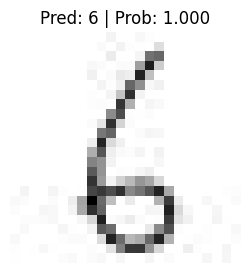

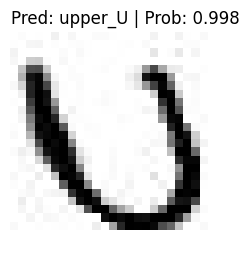

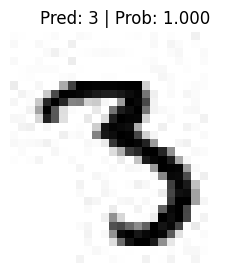

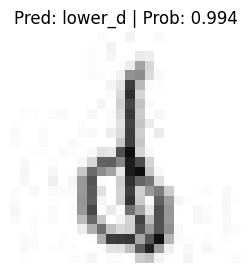

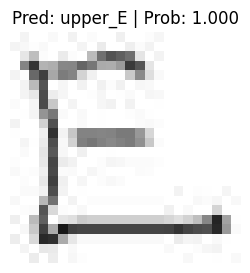

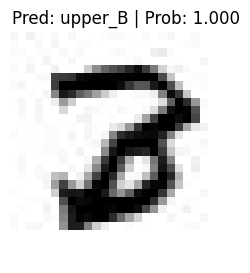

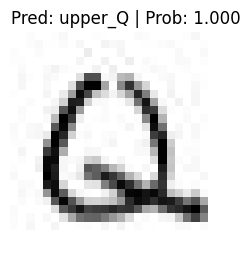

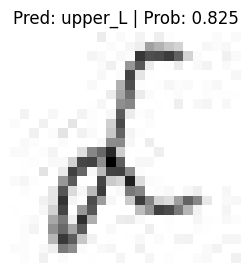

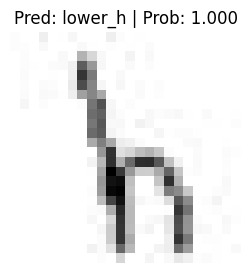

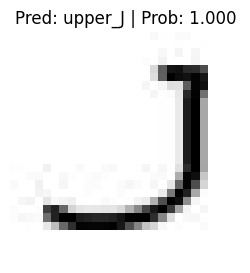

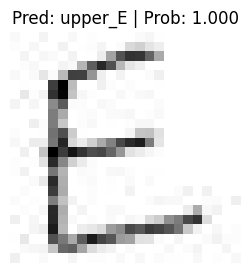

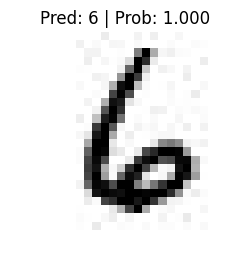

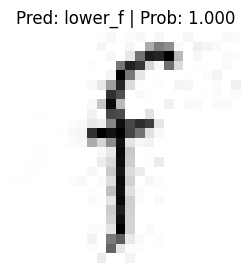

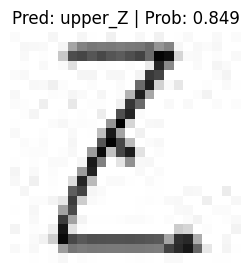

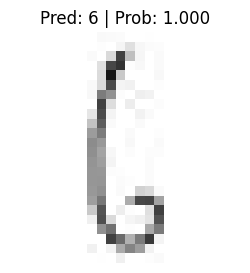

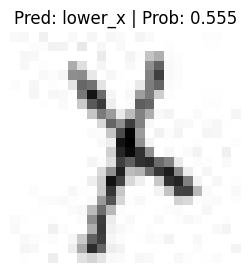

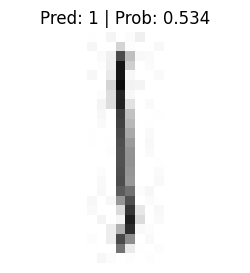

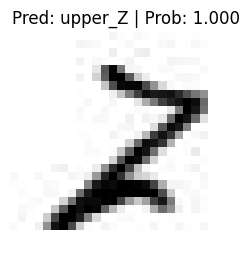

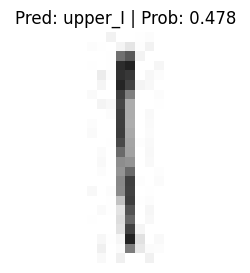

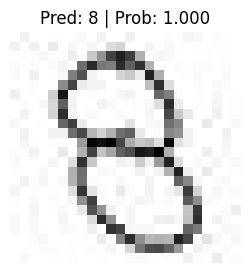

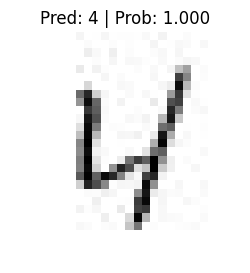

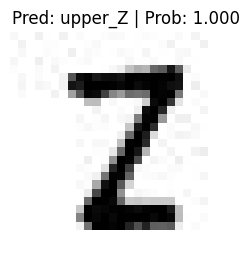

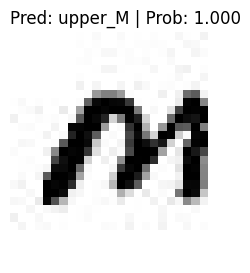

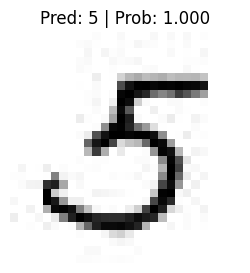

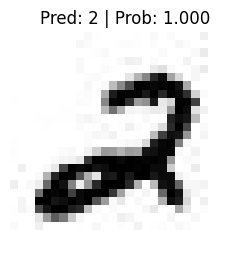

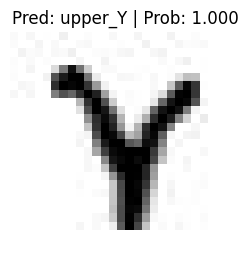

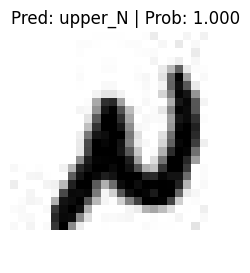

In [38]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 50
validate_image_path_list = list(Path(validate).glob("*/*.jpg")) # get list all image paths from test data 
validate_image_path_sample = random.sample(population=validate_image_path_list, # go through all of the validate image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images


from going_modular.predictions import pred_and_plot_image_GRAY

for image_path in validate_image_path_sample:
    pred_and_plot_image_GRAY(model=handwrittenCNN_Wide, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(24, 24))